### <b>Import Packages</b>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
sk.__version__

'0.23.2'

### <b>Import Data</b>

In [4]:
# df_h = pd.read_csv('/project_data/data_asset/Sample Heloc Data Dummy Values.csv')
# df_h.head()

In [3]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {'data_name': """Test_fields_100821_results.csv""", 'interaction_properties': {}}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

df1 = itcfs.read_pandas_and_concat(readClient, flightInfo)
df1.head()

,HALF,DOWNNUM,YARDSTOGO,SCOREDIFF,TIMELEFT,DOWNNAME,TRUEFIELD,YARDSGAINED_Mean,AVG_OVER_TOGO,PLAYIDSTR,RUN_PASS,CONCEPT_8,CONCEPT_9,pred_TD,prob_TD_NO,prob_TD_YES,pred_FIRST,prob_FIRST_NO,prob_FIRST_YES
0,0,0,5,0,480,1st,35,6.36,1.272,100000020,RUN,2,0,N,0.989180609,0.010819391,N,0.562406343,0.437593657
1,0,0,9,-7,1050,1st,45,4.756098,0.528455333,100000054,RUN,5,4,N,0.999278473,0.000721527,Y,0.439295772,0.560704228
2,0,2,4,7,600,3rd,5,8.164835,2.04120875,200000049,PASS,4,9,N,0.929719852,0.070280148,Y,0.391968242,0.608031758
3,0,0,11,7,180,1st,45,6.216667,0.565151545,200000041,PASS,4,1,N,0.999941376,5.86E-05,N,0.676802873,0.323197127
4,0,0,1,0,60,1st,45,13.416667,13.416667,200000085,PASS,8,5,N,0.800382789,0.199617211,N,0.60849475,0.39150525


In [6]:
from mytest_function import transform_mydata

In [7]:
df = transform_mydata(df1)
df.head()

,YARDSTOGO,SCOREDIFF,TIMELEFT,TRUEFIELD,CONCEPT_8,CONCEPT_9,YARDSGAINED_Mean,AVG_OVER_TOGO,prob_FIRST,TARGET_1ST,...,PLAYID_RUN1,PLAYID_RUN2,PLAYID_RUN3,PLAYID_RUN5,TEE_SHORT,TEE_MED,TEE_LONG,TEE_XLONG,DOWNNAME_1st,DOWNNAME_3rd
0,5,0,480,35,2,0,6.360000,1.272000,0.437594,0,...,0,1,0,0,0,1,0,0,1,0
1,9,-7,1050,45,5,4,4.756098,0.528455,0.560704,1,...,0,0,0,1,0,0,1,0,1,0
2,4,7,600,5,4,9,8.164835,2.041209,0.608032,1,...,0,0,0,0,0,1,0,0,0,1
3,11,7,180,45,4,1,6.216667,0.565152,0.323197,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,60,45,8,5,13.416667,13.416667,0.391505,0,...,0,0,0,0,1,0,0,0,1,0


## <b>Data Selection for Model Build</b>

 ### Model Build

We will build 2 models to predict First Down, one using Logistic Regression and one with Cross-Validation.

#### Data Preparation is complete. Step 1 is Sample Splitting 

First we will save a validation sample for testing the batch deployment

In [8]:
model_df = df.sample(frac=0.8, random_state=100)
#valid_df = df[~df.index.isin(model_df.index)]
print(len(model_df)) #,len(valid_df))

8000


Working with First Down predictions, we split the data, stratifying on selected data fields, always including y </br>
If desired, we can use the substitute scaled data for raw input variables. They have already been transformed into the appropriate array. 

In [9]:
from sklearn.model_selection import train_test_split

## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X = model_df.drop(columns = ['TARGET_1ST','STRAT_1ST'], axis = 1) ## We are using the same input variables, so the same scaled data will work. Only change is the target and stratification variables.
y = model_df['TARGET_1ST'].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify = model_df.STRAT_1ST, random_state=121)

Now we run the Logistic Regression model

In [10]:
from sklearn.linear_model import LogisticRegression

## https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# instantiate the model
logit = LogisticRegression()

# check the default parameters
#logit.get_params()

In [11]:
import warnings

#ignore by message
warnings.filterwarnings("ignore")

# fit the model with data using the default parameters
sk_logr = logit.fit(train_X,train_y)
sk_logr.score(test_X, test_y)

0.784375

In [12]:
import sklearn.pipeline
from sklearn.metrics import roc_curve, roc_auc_score
### call pipeline.predict() on your X_test data to make a set of test predictions
sk_pred = sk_logr.predict(test_X)

### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report(test_y, sk_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       607
           1       0.82      0.84      0.83       993

    accuracy                           0.78      1600
   macro avg       0.77      0.77      0.77      1600
weighted avg       0.78      0.78      0.78      1600



In [13]:
sklearn.metrics.f1_score(test_y, sk_pred)

0.8287841191066997

In [14]:
sk_probs = sk_logr.predict_proba(test_X)
sk_probs

array([[0.21056597, 0.78943403],
       [0.07610297, 0.92389703],
       [0.17291691, 0.82708309],
       ...,
       [0.07652876, 0.92347124],
       [0.20045445, 0.79954555],
       [0.07256404, 0.92743596]])

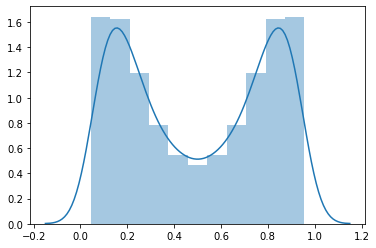

In [15]:
sns.distplot(sk_probs, kde=True, hist=True)

In [16]:
coef_logr = sk_logr.coef_
s = pd.Series(coef_logr[0])
s1 = pd.Series(10, index=X.columns)
s1_df = pd.DataFrame(s1)
s1_df[0] = s.values
#s1_df

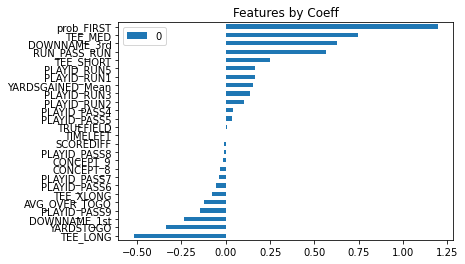

In [17]:
#LOGR_features = pd.Series(data=s1_df[0],index=df_TD.index)
s1_df.sort_values(by=0,ascending=True,inplace=True)

s1_df.plot(kind='barh')
plt.title("Features by Coeff")
plt.show()

### Build a second model using Cross Validation

In [18]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegressionCV

cv_logr = LogisticRegressionCV(cv=7, random_state=0).fit(X, y)
cv_logr.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 7,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [19]:
cv_logr.score(X, y)

0.974

In [20]:
cv_pred = cv_logr.predict(test_X)

report = sklearn.metrics.classification_report(test_y, cv_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       607
           1       0.97      0.99      0.98       993

    accuracy                           0.98      1600
   macro avg       0.98      0.97      0.97      1600
weighted avg       0.98      0.98      0.98      1600



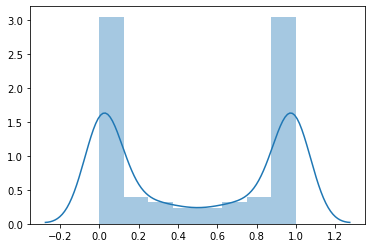

In [21]:
cv_probs = cv_logr.predict_proba(test_X)
cv_probs

sns.distplot(cv_probs, kde=True, hist=True)

### ROC Curve for Logistic Regression model

In [22]:
from my_roc_plot import plot_myroc

In [25]:
cv_probs

array([[2.95522661e-02, 9.70447734e-01],
       [2.22884572e-04, 9.99777115e-01],
       [1.26784917e-02, 9.87321508e-01],
       ...,
       [1.74205099e-04, 9.99825795e-01],
       [8.28837998e-01, 1.71162002e-01],
       [2.65203483e-01, 7.34796517e-01]])

In [23]:
myplot = plot_myroc(sk_probs, cv_probs)
myplot

NameError: name 'test_y' is not defined

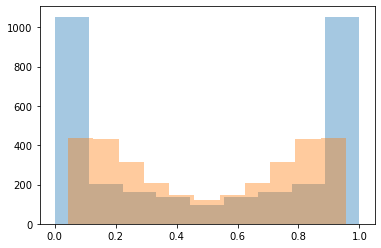

In [32]:
sns.distplot(cv_probs,hist=True,kde=False)
sns.distplot(sk_probs,hist=True,kde=False)

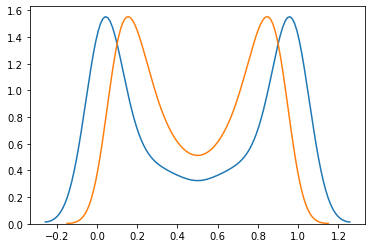

In [33]:
sns.distplot(cv_probs,hist=False,kde=True)
sns.distplot(sk_probs,hist=False,kde=True)

In [34]:
import os
import requests
import json
import time
from project_lib import Project

token = os.environ.get('USER_ACCESS_TOKEN')
project_id = os.environ.get('PROJECT_ID')
host = os.environ['RUNTIME_ENV_APSX_URL']
token

'eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IklTQWdYV2czTE5uRVVETVg0OFB2b1BnVEEybHpCYmhxaGNaZUEyN2d5X00ifQ.eyJ1aWQiOiIxMDAwMzMxMDMwIiwidXNlcm5hbWUiOiJkYW4uc2NoZXVjaEB1cy5pYm0uY29tIiwicm9sZSI6IlVzZXIiLCJwZXJtaXNzaW9ucyI6WyJjcmVhdGVfcHJvamVjdCIsImF1dGhvcl9nb3Zlcm5hbmNlX2FydGlmYWN0cyIsInZpZXdfZ292ZXJuYW5jZV9hcnRpZmFjdHMiLCJjYW5fcHJvdmlzaW9uIiwiYWNjZXNzX2NhdGFsb2ciLCJ2aWV3X3F1YWxpdHkiLCJtYW5hZ2VfaW5mb3JtYXRpb25fYXNzZXRzIiwibWFuYWdlX21ldGFkYXRhX2ltcG9ydCIsIm1hbmFnZV9kaXNjb3ZlcnkiLCJtYW5hZ2VfcXVhbGl0eSIsImNyZWF0ZV9zcGFjZSIsImFjY2Vzc19hZHZhbmNlZF9nb3Zlcm5hbmNlX2NhcGFiaWxpdGllcyIsImFjY2Vzc19hZHZhbmNlZF9tYXBwaW5nX2NhcGFiaWxpdGllcyIsIm1hbmFnZV9jYXRhbG9nIiwiYWNjZXNzX2luZm9ybWF0aW9uX2Fzc2V0cyIsIm1hbmFnZV9zcGFjZSIsIm1vbml0b3Jfc3BhY2UiLCJtYW5hZ2VfY2F0ZWdvcmllcyIsInZpZXdfcGxhdGZvcm1faGVhbHRoIiwibWFuYWdlX3Byb2plY3QiLCJtb25pdG9yX3Byb2plY3QiLCJtYW5hZ2Vfc2VydmljZV9pbnN0YW5jZXMiLCJtYW5hZ2VfZ292ZXJuYW5jZV93b3JrZmxvdyIsIm1vbml0b3JfcGxhdGZvcm0iXSwiZ3JvdXBzIjpbMTAwMDBdLCJzdWIiOiJkYW4uc2NoZXVjaEB1cy5pYm0uY29t

In [35]:
#model_df = df.sample(frac=0.8, random_state=100)
valid_df = df1[~df1.index.isin(model_df.index)]
print(len(model_df),len(valid_df))
#df1

8000 2000


In [33]:
export_filename = 'Validation_Test_file.csv'

#export = valid_df.drop(columns = ['TARGET_1ST','STRAT_1ST'], axis = 1)
export = valid_df.copy()
project = Project(project_id=project_id, project_access_token=token)
project.save_data(export_filename, export.to_csv(index=False), overwrite=True)

{'file_name': 'Validation_Test_file.csv',
 'message': 'File saved to project storage.',
 'asset_id': '9a6aab1e-0eb6-4813-a0de-7803fbe3e313'}